In [25]:
import random
import json
import pandas as pd
import datetime
import numpy as np
from numpy import savetxt, save, load
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
from scipy.special import boxcox1p
from scipy.stats import norm, skew

np.set_printoptions(precision=4,suppress=True)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 999)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

#code=utf-8

In [26]:
def fill_missing_dates(sales):
    idx = pd.date_range('04-01-2019', '11-30-2019')
    product_ids = sales.product_id.drop_duplicates().tolist()
    data = []
    for product_id in product_ids:
        df = sales[sales.product_id == product_id]
        df.index = pd.DatetimeIndex(df.date)
        df = df.reindex(idx, fill_value = np.nan)
        df.sort_index(axis=0, inplace=True, ascending=True)
        df.product_id = df.product_id.fillna(value = product_id)
        df[['qty','sales','has_freebie','freebie_price']] = df[['qty','sales','has_freebie','freebie_price']].fillna(value = 0)
        df.standard_price = df.standard_price.fillna(np.mean(df.standard_price))
        df.discount_price = df.discount_price.fillna(np.mean(df.discount_price))
        data.append(df)
    data_filled = pd.concat(data, axis=0).reset_index(drop=False)
    data_filled.drop('date',axis=1,inplace=True)
    data_filled.rename(columns = {'index':'date'}, inplace=True)
    data_filled.to_json('../data/all/all_sales_clean.json',orient='split')
    return data_filled

In [27]:
# prepare data for model to read
def data_preparation():
    # read sale data
    sale = pd.read_csv('../data/all/all_sales.csv', )
    sale.date = pd.to_datetime(sale.date, format = '%Y-%m-%d')
    sale.sort_values(by = 'date', inplace = True, ascending = True)
    sale = fill_missing_dates(sale)
    sale.set_index(['date','product_id'], inplace = True)
    sale.groupby(level = 1).count()
    # read holiday data
    holiday = pd.read_csv('../data/holiday.csv', names = ['holiday'], header = 0, parse_dates = True)
    holiday.holiday = pd.to_datetime(holiday.holiday, format = '%Y-%m-%d')
    time = pd.DataFrame(data = pd.date_range('2018-04-01', '2019-12-31', freq = 'D'), columns = ['date'])
    time.date = pd.to_datetime(time.date, format = '%Y-%m-%d')
    holiday = time.merge(holiday, how = 'left', left_on = 'date', right_on = 'holiday')
    holiday.holiday = holiday.holiday.astype(str)
    holiday.holiday = holiday.holiday.apply(lambda x : 0 if x=="NaT" else 1)
    holiday.holiday.astype(int)
    holiday.set_index('date', inplace = True)
    # read session data
    session  = pd.read_csv('../data/all/all_session.csv')
    session.date = pd.to_datetime(session.date, format = '%Y-%m-%d')
    session.sort_values(by = 'date', inplace = True, ascending = True)
    session = session.merge(holiday, how = 'inner', left_on = 'date', right_index = True)
    session.set_index(['date','product_id'], inplace = True)

    # join sale and session
    sales = sale.merge(session, how = 'inner', left_index = True, right_index = True, copy = True)
    
    # fill missing values
    sales.promotion_type = sales.promotion_type.fillna(value = 'NO DISCOUNT')
    sales.multibuy_unit_price = sales.multibuy_unit_price.fillna(value = 0)
    sales.discount_price = sales.discount_price.fillna(value = 0)
    sales.freebie_price = sales.freebie_price.fillna(value = 0)
    int_var = ['holiday','has_freebie']
    sales[int_var] = sales[int_var].apply(np.int64)
    sales.impression = sales.impression.mask(sales.impression == 0, 1) # fill with 1 to get addTocart / impression
    sales.addTocart = sales.addTocart.mask(sales.addTocart == 0, 0.1) # fill with 0.1 to get qty / addTocart
    sales = sales.reset_index(drop = False)
    sale.sort_values(by = 'date', inplace = True, ascending = True)
    sales.to_json('../data/all/data.json',orient = 'split')

    return 1

In [28]:
def read_data():
    sales = pd.read_json('../data/all/data.json',orient = 'split')
    product_list = pd.read_csv('../data/product.csv', index_col = 0,encoding='ISO-8859-1')
    sales = sales.merge(product_list, how = 'left', left_on = 'product_id', right_on = 'product_id').set_index(['product_name'])
    products = sales.index.drop_duplicates().tolist()
    product_ids = sales.product_id.drop_duplicates().tolist()
    group = pd.read_csv('../data/all/segmentation/product_segmentation.csv', index_col = 0)
    group = group.loc[product_ids,]
    return sales, products, product_ids, group

In [29]:
# feature engineering
def feature_engineering(sales):
    # session conversion features
    sales.insert(0, 'add_impression', sales.addTocart / sales.impression, True)
    sales.insert(0, 'qty_add', sales.qty / sales.addTocart, True)
    
    # for discount promotion type
    discount = (sales.standard_price - sales.discount_price) / sales.standard_price
    sales.insert(0,'discount', discount, True)
    sales.discount = sales.discount.mask(sales.discount_price == sales.standard_price, 1)
    
    # for multibuy promotion type
    multibuy_discount = (sales.standard_price - sales.multibuy_unit_price) / sales.standard_price
    sales.insert(0,'multibuy_discount', multibuy_discount, True)
    
    # drop original prices
    sales = sales.drop(['standard_price', 'multibuy_unit_price', 'discount_price', 'promotion_type'], axis = 1)
    
    sales.reset_index(inplace = True)
    sales.to_json('../data/all/data_feature_engineer.json',orient='split')
    return sales

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 

def scaling(data):
    column_trans = ColumnTransformer( [('sales', MinMaxScaler(), ['sales']),
                                       ('impression', MinMaxScaler(), ['impression']),
                                       ('addTocart', MinMaxScaler(), ['addTocart']),
                                       ('click', MinMaxScaler(), ['click']),
                                       ('purchase', MinMaxScaler(), ['purchase']),
                                       ('freebie_price', RobustScaler(), ['freebie_price'])],
                                        remainder='passthrough')
    data_norm = column_trans.fit_transform(data)
    return data_norm

In [32]:
from sklearn import metrics

def mean_absolute_percent_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid divide by 0
    y_true = y_true + 0.1
    return round(np.mean(np.abs((y_true - y_pred) / y_true)), 2)

def eval_metrics(y_test, y_pred):
    rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2)
    mape = mean_absolute_percent_error(y_test, y_pred)
    return rmse, mape

In [33]:
def plot_predict(y_test, y_pred, group_id, product_id):
    # plot predict and actual for one product
    plt.figure(figsize = [20,6])
    plt.plot(y_test.qty, label = 'Actual sales qty', color = 'blue', linestyle = 'dashed', linewidth = 1)
    plt.plot(y_pred, label = 'Predict sales qty', color = 'red', linewidth = 1)
    plt.title(('Qty for group %d, product %d') % (int(group_id), product_id))
    plt.legend()
    return

In [34]:
def series_to_supervised_boosting(sales, product_ids, group_id, timestep = 1, split_ratio = 0.7): 
    X_train, X_test, Y_train, Y_test = list(), list(), list(), list()
    for id in product_ids:
        # skip the data without enough training data
        data = sales.loc[id,:]
        if len(data) < (timestep + 1)*7:
            product_ids.remove(id)
            print(id)
            continue 
        
        # change index from product_id to date
        try:
            data = data.set_index('date')
        except:
            product_ids.remove(id)
            print(id)
            continue
        
        # predict qty data of the week after next week
        qty = data.qty
        qty = qty.drop(qty.index[0:(timestep+1)*7]).reset_index(drop=True)
        
        # adjust the order of features to the order after scaling
        features = data.columns.tolist()
        for item in ['freebie_price','purchase','click','addTocart','impression','sales']:
            features.remove(item)
            features.insert(0,item)
        
        # perform scaling on predictors, return dataframe object
        data_norm = pd.DataFrame(scaling(data), index = data.index, columns = features).reset_index(drop=True)
        data_norm = data_norm.drop(['qty','product_id'], axis = 1) # exclude qty in X
        
        # prepare rolling X
        data_roll = data_norm.copy()
        for i in range(1,(timestep*7)):
            data_roll = data_roll.iloc[1:,].reset_index(drop=True)
            data_norm = data_norm.merge(data_roll, how = 'left', left_index = True, right_index = True, 
                                        suffixes=('', '(t+%d)' % (i) )).reset_index(drop=True)
        
        # split train and test data by product, save to dict
        data_norm = data_norm.merge(qty, how = 'inner', left_index = True, right_index = True).dropna()
        data_norm.insert(0, 'product_id', id)
        
        train_size = int(len(data_norm) * split_ratio)
        X_train.append(data_norm.iloc[:train_size, ].drop('qty',axis = 1))
        X_test.append(data_norm.iloc[train_size:, ].drop('qty',axis = 1))
        Y_train.append(data_norm[['qty', 'product_id']].iloc[:train_size, ])
        Y_test.append(data_norm[['qty', 'product_id']].iloc[train_size:, ])
    
    # concat all data to dataframes, save as csv
    X_train_csv = pd.concat(X_train).reset_index(drop=True)
    X_test_csv = pd.concat(X_test).reset_index(drop=True)
    Y_train_csv = pd.concat(Y_train).reset_index(drop=True)
    Y_test_csv = pd.concat(Y_test).reset_index(drop=True)
    
    X_train_csv.to_json('../data/all/boosting_input_data/group%d_X_train.json' % (group_id), orient='split')
    X_test_csv.to_json('../data/all/boosting_input_data/group%d_X_test.json' % (group_id), orient='split')
    Y_train_csv.to_json('../data/all/boosting_input_data/group%d_Y_train.json' % (group_id), orient='split')
    Y_test_csv.to_json('../data/all/boosting_input_data/group%d_Y_test.json' % (group_id), orient='split')
    return product_ids

In [40]:
# construct X and Y for one product group
def series_to_supervised_rnn(sales, product_ids, group_id, timestep = 1, split_ratio = 0.7): 
    X_train, X_test, Y_train, Y_test = list(), list(), list(), list()
    total_train_size, total_samples = 0, 0
    
    for id in product_ids:
        # not enough training data
        data = sales.loc[id,:]
        if len(data) < (timestep + 1)*7:
            product_ids.remove(id)
            print(id)
            continue
        # change index from product_id to date
        try:
            data = data.set_index('date')
            data.sort_index(axis=0,ascending=True, inplace=True)
        except:
            product_ids.remove(id)
            print(id)
            continue
            
        # add back product_id for reference, use one-week qty as target variable
        qty = data[['product_id','qty']]
        qty.qty = qty.qty.rolling(window = 7).sum().dropna()
        qty = qty.dropna()
        
        # adjust the order of features to the order after scaling
        features = data.columns.tolist()
        for item in ['freebie_price','purchase','click','addTocart','impression','sales']:
            features.remove(item)
            features.insert(0,item)
        
        # perform scaling on predictors, return still dataframe object
        data_norm = pd.DataFrame(scaling(data), index = data.index, columns = features)
        # move product_id to the first column
        features.remove('product_id')
        features.insert(0, 'product_id')
        data_norm = data_norm[features]
        # add back product_id for reference
        n_features = data_norm.shape[1]
        
        # prepare 3d array for X
        n_samples = len(data_norm) - (timestep + 1) * 7 - 6
        train_size = int(n_samples * split_ratio)
        total_train_size += train_size
        total_samples += n_samples
        for i in range(train_size): # train_samples for one product
            sample = []
            for j in range(timestep*7):
                sample.append(data_norm.iloc[i+j,:])
            X_train.append(sample)
            
        for i in range(train_size, n_samples):
            sample = []
            for j in range(timestep*7):
                sample.append(data_norm.iloc[i+j,:])
            X_test.append(sample)         
        
        # prepare 2d array for Y, predict qty(t+2)
        for i in range(train_size):
            Y_train.append([qty.iloc[(timestep + 1) * 7 + i, :]])

        for i in range(train_size, n_samples):
            Y_test.append([qty.iloc[(timestep + 1) * 7 + i, :]])
    X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)
    print(group_id, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape) 
    X_train = np.reshape(X_train, (total_train_size, timestep*7, n_features))
    X_test = np.reshape(X_test, (total_samples - total_train_size, timestep*7, n_features))    
    Y_train = np.reshape(Y_train, (total_train_size, 2)) # qty and product_id
    Y_test = np.reshape(Y_test, (total_samples - total_train_size, 2)) # qty and product_id

    save('../data/all/rnn_input_data/group%d_X_train.npy' % (group_id), X_train)
    save('../data/all/rnn_input_data/group%d_X_test.npy' % (group_id), X_test)
    save('../data/all/rnn_input_data/group%d_Y_train.npy' % (group_id), Y_train)
    save('../data/all/rnn_input_data/group%d_Y_test.npy' % (group_id), Y_test) 
    return product_ids

In [54]:
def preprocessing(data, product_ids, group, timestep, model):
    
    # feature engineering
    sales = feature_engineering(data)
    sales = pd.read_json('../data/all/data_feature_engineer.json', orient='split')
    
    sales = sales.sort_values('date').set_index(['product_id'], drop=False) 
    # prepare predictor, delete features: click, purchase
    variables = sales.columns.tolist()
    for item in ['product_name','category_id','checkout','category']:
        variables.remove(item)
    
    # separate sales data by product group
    group_ids = group.group.drop_duplicates().dropna().tolist()
    # save group_id, group_product_ids to json file
    with open("../data/all/group_ids.json", "w") as outfile:
        json.dump(group_ids, outfile)
        
    group_product_ids = {}
    for group_id in group_ids:
        if int(group_id == 2):
            group_product_ids[group_id] = group[group.group == group_id].index.tolist()
            group_sales = sales.loc[group_product_ids[group_id],:]
            if model == 'rnn':
                group_product_ids[group_id] = series_to_supervised_rnn(group_sales[variables], 
                                                                       group_product_ids[group_id],group_id, timestep)
            else:
                group_product_ids[group_id] = series_to_supervised_boosting(group_sales[variables], 
                                                                            group_product_ids[group_id],group_id, timestep)
    
#     with open("../data/all/group_product_ids.json", "w") as outfile:
#         json.dump(group_product_ids, outfile)
        
    return group_ids, group_product_ids   

In [55]:
pd.set_option('mode.chained_assignment', None)
# data_preparation()
# sales, products, product_ids, group = read_data()
timestep = 2
group_ids, group_product_ids = preprocessing(sales, product_ids, group, timestep, 'rnn')

75841
75641
80717
79707
75616
82907
75666
79697
83347
75816
75656
75951
75696
75631
75621
75736
75766
75926
75996
75611
75776
75906
75676
75981
75826
75966
75651
75771
75781
75946
75741
75916
75751
75796
44797
75606
2.0 (86607, 14, 74) (37959, 14, 74) (86607, 1, 2) (37959, 1, 2)


In [11]:
# lightGBM
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

def lightgbm_model(x_train, x_test, y_train, y_test, group_id): 
    features = x_train.columns.tolist()
    features.remove('product_id')
    lgb_train = lgb.Dataset(x_train[features], y_train.qty) 
    lgb_test = lgb.Dataset(x_test[features], y_test.qty, reference=lgb_train)

    params = {'objective': 'regression', 
        'learning_rate': 0.03, 'lambda_l1': 0.5, 'metric': {'mape','rmse'},  
        'max_depth': 6, 'num_leaves': 64, 'min_data_in_leaf': 30, 
        'colsample_bytree': 0.7, 'subsample': 0.7, 'subsample_freq': 50,  
        'verbose': 0 }
    
    gridParams = {
          'max_depth': [6, 8],
          'num_leaves': [64, 126],
          'min_child_samples' : [30, 40, 50],
          'reg_alpha': [0.001, 0.01, 0.03]}
    
    print("Start GridSearch for Parameters")
    lg = lgb.LGBMRegressor(objective = 'regression', n_jobs = 3, n_estimators = 1000, silent = True, metric = 'rmse')
    grid = GridSearchCV(lg, gridParams, verbose=0, cv=4, n_jobs=3)
    # convert data to list to fit GridSearch
    grid.fit(x_train[features], y_train.qty)
    print(grid.best_params_)
    print(grid.best_score_)
    
    params['max_depth'] = grid.best_params_['max_depth']
    params['num_leaves'] = grid.best_params_['num_leaves']
    params['min_data_in_leaf'] = grid.best_params_['min_child_samples']
    params['lambda_l1'] = grid.best_params_['reg_alpha']
    
    evals_result = {}
    print("Start Model Training")
    lg_model = lgb.train(params,lgb_train,num_boost_round=1000, valid_sets=lgb_test,
                evals_result=evals_result,verbose_eval=200, early_stopping_rounds = 200)   
    
    from sklearn.externals import joblib
    joblib.dump(lg_model, 'lg_model%d.pkl' % (group_id))
    print("LightGBM Model dumped!")
    
    model_columns = list(x_train.columns)
    joblib.dump(model_columns, 'lg_model%d_column.pkl' % (group_id))
    print("LightGBM Models columns dumped!")

    # plot training result
    ax = lgb.plot_metric(evals_result, metric='rmse')
    plt.show()
    return 1

Start GridSearch for Parameters
{'max_depth': 8, 'min_child_samples': 30, 'num_leaves': 64, 'reg_alpha': 0.03}
-0.26597271057970834
Start Model Training
Training until validation scores don't improve for 200 rounds
[200]	valid_0's mape: 3.6856	valid_0's rmse: 96.2569
Early stopping, best iteration is:
[57]	valid_0's mape: 3.41144	valid_0's rmse: 96.7184
LightGBM Model dumped!
LightGBM Models columns dumped!


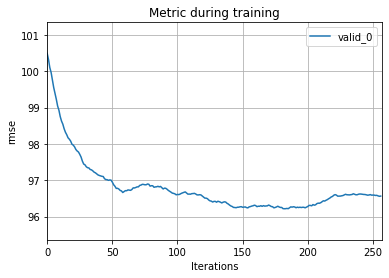

1.0 2930 2930


ZeroDivisionError: division by zero

In [19]:
timestep = 1
from sklearn.externals import joblib

import json
with open("../data/all/group_ids.json") as json_file:
    group_ids = json.load(json_file)

with open("../data/all/group_product_ids.json") as json_file:
    group_product_ids = json.load(json_file)

rmse, mape, X_train, X_test, Y_train, Y_test = {}, {}, {}, {}, {}, {}

for index, group_id in enumerate(group_ids):
    X_train[group_id] = pd.read_csv('../data/all/boosting_input_data/group%d_X_train.csv' % (group_id), index_col = 0)
    X_test[group_id] = pd.read_csv('../data/all/boosting_input_data/group%d_X_test.csv' % (group_id), index_col = 0)
    Y_train[group_id] = pd.read_csv('../data/all/boosting_input_data/group%d_Y_train.csv' % (group_id), index_col = 0)
    Y_test[group_id] = pd.read_csv('../data/all/boosting_input_data/group%d_Y_test.csv' % (group_id), index_col = 0)
#     try:
#         lg_model = joblib.load("lg_model%d.pkl" % (group_id) )
#         lg_model_columns = joblib.load("lg_model%d_column.pkl" % (group_id))
#     except:
    lightgbm_model(X_train[group_id], X_test[group_id], Y_train[group_id], Y_test[group_id], group_id)
    lg_model = joblib.load("lg_model%d.pkl" % (group_id) )
    lg_model_columns = joblib.load("lg_model%d_column.pkl" % (group_id))

    # random select n products for prediction
    n = len(group_product_ids[str(group_id)])
    ncols = 2
    nrows = int(n / ncols)
    selected_product = random.sample(group_product_ids[str(group_id)], n)
    selected_product = group_product_ids[str(group_id)]
    _rmse, _mape = 0, 0
#     fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,10))
#     plt.subplots_adjust(wspace=0.1)
    x_test_group, y_test_group = X_test[group_id], Y_test[group_id]
    skip = 0
#     for i in range(nrows):
#         for j in range(ncols):
    for i in range(n):
            # y_test: dataframe, y_pred: ndarray
#         product_id = selected_product[ncols*i+j]
        product_id = selected_product[i]
        x_test = x_test_group[x_test_group.product_id == product_id]
        x_test = x_test.drop('product_id', axis =1)
        y_test = y_test_group[y_test_group.product_id == product_id]
        try: 
            y_pred = lg_model.predict(x_test, num_iteration=lg_model.best_iteration)
        except:
            skip += 1
            continue
        y_pred = pd.Series(y_pred).reset_index(drop=True)
        y_test = y_test.reset_index(drop=True)
#             ax[i][j].plot(y_test.qty, linewidth = 1, label = 'Actual sales qty', color = 'blue', linestyle = 'dashed')
#             ax[i][j].plot(y_pred, linewidth = 1, label = 'Predict sales qty', color = 'red')
#             title = 'Qty for group %d, product %d, rmse: %f, mape: %f' % (int(group_id), product_id, 
#                                                                      round(eval_metrics(y_test.qty, y_pred)[0], 2), 
#                                                                      round(eval_metrics(y_test.qty, y_pred)[1],2))
#             ax[i][j].set_title(title)
        _rmse += eval_metrics(y_test.qty, y_pred)[0]
        _mape += eval_metrics(y_test.qty, y_pred)[1]
#     plt.show()
    print(group_id, n, skip)
    rmse[group_id], mape[group_id] = round(_rmse / (n-skip), 2), round(_mape / (n-skip), 2)

Model = 'LightGBM'
table = [[Model, 0, len(group_product_ids[str(0.0)]), rmse[0], mape[0]],
         [Model, 1, len(group_product_ids[str(1.0)]), rmse[1], mape[1]],
         [Model, 2, len(group_product_ids[str(2.0)]), rmse[2], mape[2]],
         [Model, 3, len(group_product_ids[str(3.0)]), rmse[3], mape[3]]]

print(tabulate(table, headers=["Model","Group", "Num_Products", "RMSE", "MAPE"]))

In [73]:
# bug, https://stackoverflow.com/questions/55496289/how-to-fix-attributeerror-module-tensorflow-has-no-attribute-get-default-gr
from tensorflow.keras import backend
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Flatten, LSTM, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers

def rnn(x_train, x_test, y_train, y_test, group_id):
    np.random.seed(11)
    # exclude product_id feature
    x_train, x_test = x_train[:,:,1:], x_test[:,:,1:]
    y_train, y_test = y_train[:,1], y_test[:,1]
    
    model = Sequential()
    # add batch normalization
    model.add(BatchNormalization())
    model.add(LSTM(8, activation= 'elu', input_shape=(x_train.shape[1], x_train.shape[2]), 
                   return_sequences = True)) # n_samples, input_shape = [timestep, n_features]
    model.add(Dropout(0.2))
    model.add(LSTM(8, activation='elu', 
                   return_sequences = False)) 
    # add more linear dense layers
    model.add(Dense(32, activation = 'elu',
                    kernel_initializer = 'random_uniform'))
    model.add(Dense(16, activation = 'elu',
                    kernel_initializer = 'random_uniform'))
    model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1, activation = 'relu'))
    optimizer = optimizers.Adam(lr=0.04, beta_1=0.9, beta_2=0.965)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    print("start LSTM model training")
    history = model.fit(x=x_train, y=y_train,
                    validation_data=[x_test, y_test],
                    epochs=500, batch_size=100, verbose=2,
                   callbacks = [EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode='min')])
    model.summary()
#     mc = ModelCheckpoint('lstm_model%d.h5' % (group_id), monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    model.save('lstm_model%d.h5' % (group_id))
    print('LSTM Model Saved')
    
    # plot history
    print("plot loss function")
    plt.figure(figsize = [10,4])
    plt.plot(history.history['loss'], label='mse_train')
    plt.plot(history.history['val_loss'], label='mse_test')
    plt.legend()
    plt.show()
    
    return model

start LSTM model training
Train on 86607 samples, validate on 37959 samples
Epoch 1/500
86607/86607 - 53s - loss: 88.9906 - val_loss: 118.8060
Epoch 2/500
86607/86607 - 14s - loss: 85.8459 - val_loss: 120.0986
Epoch 3/500
86607/86607 - 14s - loss: 91.2957 - val_loss: 119.2421
Epoch 4/500
86607/86607 - 13s - loss: 90.3580 - val_loss: 129.2678
Epoch 5/500
86607/86607 - 14s - loss: 94.2951 - val_loss: 130.0684
Epoch 6/500
86607/86607 - 13s - loss: 101.8475 - val_loss: 130.3469
Epoch 7/500
86607/86607 - 14s - loss: 107.6873 - val_loss: 129.3875
Epoch 8/500
86607/86607 - 14s - loss: 1382.7031 - val_loss: 129.7637
Epoch 9/500
86607/86607 - 13s - loss: 94.1197 - val_loss: 129.5820
Epoch 10/500
86607/86607 - 13s - loss: 93.7559 - val_loss: 129.6084
Epoch 11/500
86607/86607 - 13s - loss: 93.7709 - val_loss: 130.6568
Epoch 12/500
86607/86607 - 14s - loss: 93.7899 - val_loss: 129.8596
Epoch 13/500
86607/86607 - 14s - loss: 311.7910 - val_loss: 129.9667
Epoch 14/500
86607/86607 - 13s - loss: 93.77

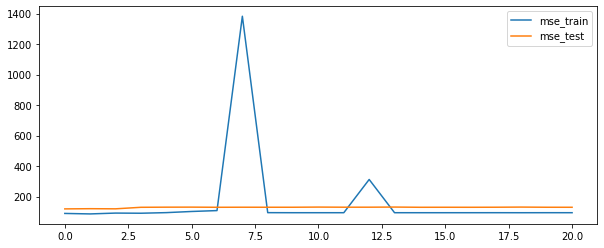

In [74]:
import json
with open("../data/all/group_ids.json") as json_file:
    group_ids = json.load(json_file)

with open("../data/all/group_product_ids.json") as json_file:
    group_product_ids = json.load(json_file)

X_train, X_test, Y_train, Y_test = {}, {}, {}, {}

for index, group_id in enumerate(group_ids):
    if int(group_id) == 2:
        X_train[group_id] = load('../data/all/rnn_input_data/group%d_X_train.npy' % (group_id))
        X_test[group_id] = load('../data/all/rnn_input_data/group%d_X_test.npy' % (group_id))
        Y_train[group_id] = load('../data/all/rnn_input_data/group%d_Y_train.npy' % (group_id))
        Y_test[group_id] = load('../data/all/rnn_input_data/group%d_Y_test.npy' % (group_id))
        model = rnn(X_train[group_id], X_test[group_id], Y_train[group_id], Y_test[group_id], group_id)

In [ ]:
import json
with open("../data/all/group_ids.json") as json_file:
    group_ids = json.load(json_file)

with open("../data/all/group_product_ids.json") as json_file:
    group_product_ids = json.load(json_file)

# group_product_ids = [174,15709,185,1796,70046,976,1210,6264,21950,19755,9351,2595]
timestep = 2
rmse, mape, X_train, X_test, Y_train, Y_test = {}, {}, {}, {}, {}, {}

for index, group_id in enumerate(group_ids):
    if int(group_id) == 2:
        X_train[group_id] = load('../data/all/rnn_input_data/group%d_X_train.npy' % (group_id))
        X_test[group_id] = load('../data/all/rnn_input_data/group%d_X_test.npy' % (group_id))
        Y_train[group_id] = load('../data/all/rnn_input_data/group%d_Y_train.npy' % (group_id))
        Y_test[group_id] = load('../data/all/rnn_input_data/group%d_Y_test.npy' % (group_id))
        from tensorflow.keras.models import load_model
        lstm_model = load_model('lstm_model%d.h5' % (group_id))
        print('LSTM Model Loaded!')

        # random select n products for prediction
        n = 16
        ncols = 2
        nrows = int(n / ncols)
        selected_product = random.sample(group_product_ids[str(group_id)], n)
#         selected_product = random.sample(group_product_ids, n)
#         selected_product = group_product_ids
        _rmse, _mape = 0, 0
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(20,50))
        plt.subplots_adjust(wspace=0.1)
        for i in range(nrows):
            for j in range(ncols):
#         for i in range(n):
            # y_test: ndarray, y_pred: ndarray with product_id
                product_id = selected_product[ncols*i+j]
    #             product_id = selected_product[i]
                x_test, y_test = X_test[group_id], Y_test[group_id]
                # select the data for one product, exclude product_id from features
                x_test = x_test[x_test[:,:,0] == product_id]
                x_test = x_test.reshape(int(x_test.shape[0] / (timestep*7)), timestep*7, x_test.shape[1])[:,:,1:]
                y_test = y_test[y_test[:,0] == product_id][:,1]
                y_pred = lstm_model.predict(x_test)
                y_pred = pd.Series(y_pred.reshape(len(y_pred)))
                y_test = pd.Series(y_test.reshape(len(y_test)))
                ax[i][j].plot(y_test, linewidth = 1, label = 'Actual sales qty', color = 'blue', linestyle = 'dashed')
                ax[i][j].plot(y_pred, linewidth = 1, label = 'Predict sales qty', color = 'red')

                title = 'Qty for group %d, product %d, rmse: %f, mape: %f' % (int(group_id), product_id, 
                                                                         round(eval_metrics(y_test, y_pred)[0], 2), 
                                                                         round(eval_metrics(y_test, y_pred)[1],2))
                ax[i][j].set_title(title)
                _rmse += eval_metrics(y_test, y_pred)[0]
                _mape += eval_metrics(y_test, y_pred)[1]
        plt.show()
        rmse[group_id], mape[group_id] = round(_rmse / n, 2), round(_mape / n, 2)

Model = 'LSTM'
table = [[Model, 2, len(group_product_ids[str(group_id)]), rmse[2], mape[2]]]

print(tabulate(table, headers=["Model","Group", "Num_Products", "RMSE", "MAPE"]))

LSTM Model Loaded!
